# Audio embeddings using deep LSTM autoencoder

Firstly, we import a mono audio sample for testing.

In [179]:
from helpers import wav_to_array_dialog
audio = wav_to_array_dialog()
test_audio = wav_to_array_dialog()

Then, we perform a gammatone spectral analysis on a part of the audio. Let's test it on a segment of audio with a spectral resolution of 200 frequency bins and a temporal resolution of 0.025 seconds. We plot it to demonstrate its properties.

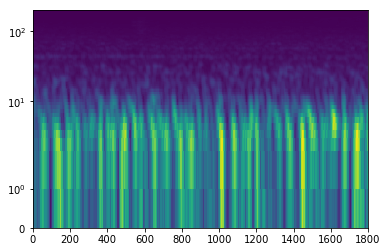

In [181]:
from data import perform_gammatone_spectrogram
test_gammatone = perform_gammatone_spectrogram(audio[500000:600000], 44100, 0.025, 0.00125, 200, 30)

import matplotlib.pyplot as plt
plt.pcolormesh(test_gammatone)
plt.yscale('symlog')
plt.show()

Let's try organizing the frequencies in dilated spectral frames. We will instantiate a GammatoneFilterbank and have it perform dilated spectral analysis on a segment of audio. We plot a single frame to demonstrate its properties.

- Temporal resolution: 0.01 seconds per frame (~440 samples per frame)
- Spectral resolution: 100 filters
- Num historic frames: 10
- Dilation factor: 2 (translates to 2^n for historic frames)

In [182]:
# Prepare dilated gammatone processing
from gammatone_filterbank import GammatoneFilterbank
filterbank = GammatoneFilterbank(44100, 0.01, 0.0005, 100, 30)

# Make train and test sets
train = filterbank.make_dilated_spectral_frames(audio, 10, 2)
test = filterbank.make_dilated_spectral_frames(test_audio, 10, 2)

# Normalize values across spectrogram
train = train/train.max()
test = test/test.max()

Let's plot some examples from the training and validation data.

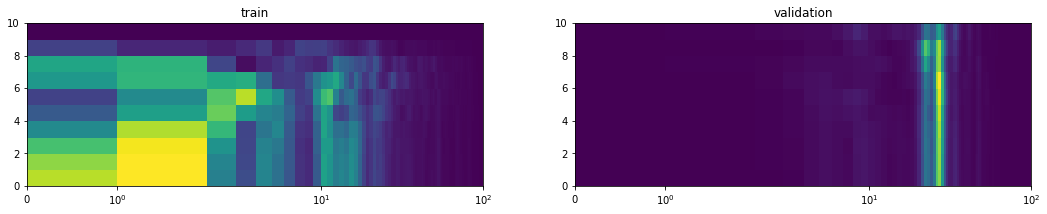

In [183]:
# Plot and print data
plt.figure(figsize=(18,3))
plt.subplot(1, 2, 1)
plt.xscale('symlog')
plt.title('train')
plt.pcolormesh(train[500])
plt.subplot(1, 2, 2)
plt.xscale('symlog')
plt.title('validation')
plt.pcolormesh(test[600])
plt.show()

We want to try and use these frames of dilated frequencies to create usable immediate audio embeddings which can be used in neural networks. We prepare an LSTM Autoencoder for this purpose.

In [95]:
from model import prepare_model
autoencoder, encoder = prepare_model(10, 100, 300, "rmsprop", "mean_squared_error")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 10, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 10, 50)            30200     
_________________________________________________________________
lstm_10 (LSTM)               (None, 300)               421200    
_________________________________________________________________
repeat_vector_3 (RepeatVecto (None, 10, 300)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 10, 50)            70200     
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 100)           60400     
Total params: 582,000
Trainable params: 582,000
Non-trainable params: 0
_________________________________________________________________
None

Now that the autoencoder model has been prepared, let's fit it and plot the results!

In [ ]:
autoencoder.load_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/LSTM1_weights.h5")
history = autoencoder.fit(train, train, epochs=10, batch_size=250, validation_data=(test, test))

Train on 673508 samples, validate on 152326 samples
Epoch 1/10
673508/673508 [==============================] - 598s - loss: 5.6285e-05 - acc: 0.5645 - val_loss: 6.4644e-05 - val_acc: 0.6397
Epoch 2/10
673508/673508 [==============================] - 598s - loss: 4.8437e-05 - acc: 0.5768 - val_loss: 7.2558e-05 - val_acc: 0.6302
Epoch 3/10
673508/673508 [==============================] - 616s - loss: 4.5432e-05 - acc: 0.5839 - val_loss: 9.1331e-05 - val_acc: 0.6010
Epoch 4/10
673508/673508 [==============================] - 628s - loss: 4.3414e-05 - acc: 0.5893 - val_loss: 8.0986e-05 - val_acc: 0.6244
Epoch 5/10
673508/673508 [==============================] - 621s - loss: 4.1842e-05 - acc: 0.5931 - val_loss: 6.0262e-05 - val_acc: 0.6389
Epoch 6/10
673508/673508 [==============================] - 641s - loss: 4.0572e-05 - acc: 0.5965 - val_loss: 6.5429e-05 - val_acc: 0.6292
Epoch 7/10
673508/673508 [==============================] - 655s - loss: 3.9498e-05 - acc: 0.5998 - val_loss: 5.32

dict_keys(['val_acc', 'loss', 'val_loss', 'acc'])


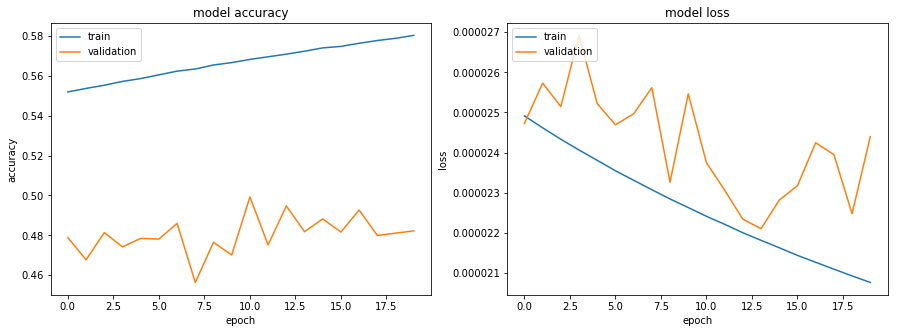

In [104]:
print(history.history.keys())
#  "Accuracy"
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
# "Loss"
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Now that we've fit our model, let's save its weights.

In [188]:
# save_path = get_save_path()
autoencoder.save_weights("C:/Users/Rothmann/Documents/PROJECTS/Development/Thesis/Keras/Models/LSTM_Autoencoder/LSTM1_weights.h5")

Now let's predict some encodings to compare the encoded data with the original:

In [184]:
prediction = autoencoder.predict(x=test[:10000], batch_size=200, verbose=True)

110000/110000 [==============================] - 32s    


We'll plot a few of these encodings to get an idea of how well it worked. Looks like the temporal context is reconstructing quite well!

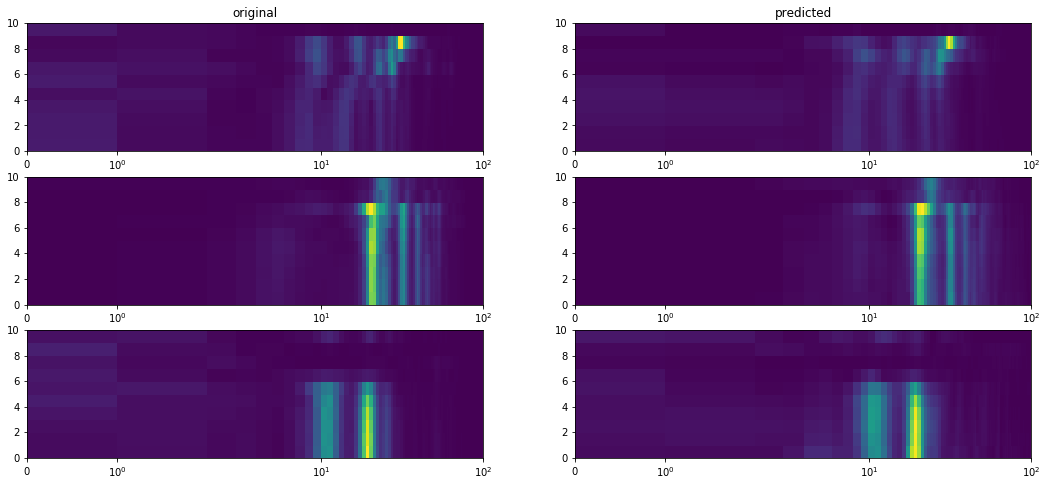

In [187]:
from random import *

plt.figure(figsize=(18,8))

for i in range(3):
    rand_example = randint(1, 10000
    
    plt.subplot(3, 2, i * 2 + 1)
    plt.xscale('symlog')
    if i == 0:
        plt.title('original')
    plt.pcolormesh(test[rand_example])
    
    plt.subplot(3, 2,  i * 2 + 2)
    plt.xscale('symlog')
    if i == 0:
        plt.title('predicted')
    plt.pcolormesh(prediction[rand_example])
     
plt.show()